# Code for model estimation

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [249]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [21]:
l = 1
set_id = 3
fold_n = 0
validation_file_path="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation_logits_predictions.csv".format(l, set_id, fold_n)
train_file_path="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train_logits_predictions.csv".format(l, set_id, fold_n)

df_val = pd.read_csv(validation_file_path, index_col=0)
df_train = pd.read_csv(train_file_path, index_col=0)


In [22]:
df_val

,true_value,pred_value,logit_0,logit_1,logit_2,logit_3
0,0.0,0.0,7.228590,1.182683,-9.144910,0.821133
1,0.0,1.0,-2.171190,4.303228,1.489726,-3.514802
2,0.0,3.0,-0.498028,1.343088,-2.613964,1.785451
3,0.0,0.0,3.313532,1.838850,-3.935349,-1.103022
4,0.0,0.0,3.737225,0.665229,-4.721802,0.427954
...,...,...,...,...,...,...
85,3.0,2.0,-1.834696,-0.265494,1.215321,0.964535
86,3.0,3.0,-5.114456,1.066253,0.791766,3.227256
87,3.0,3.0,-1.319067,-1.703586,-0.172870,3.213687
88,3.0,1.0,-4.126339,3.423990,-0.835683,1.390611


In [113]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df_val['true_value'], df_val['pred_value'], average='weighted')

(0.6997584541062801, 0.6888888888888889, 0.6813083779442063, None)

In [ ]:
# https://stackoverflow.com/questions/55541254/precision-recall-curve-with-n-fold-cross-validation-showing-standard-deviation

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from numpy import interp

X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=10.0,
    random_state=10)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=10)

y_real = []
y_proba = []

precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = numpy.concatenate(y_real)
y_proba = numpy.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.show()

# Metrics calculation

In [276]:
from sklearn.metrics import roc_auc_score

class MultiClassMetrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        
    def calculate_scores(self, class_mapping_dict=None):
    
        y_true_ = self.y_true
        y_pred_ = self.y_pred
        if classes_map_dict is not None:
            y_true_ = y_true_.map(classes_map_dict)
            y_pred_ = y_pred_.map(classes_map_dict)
    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        self.FP = self.cnf_matrix.sum(axis=0) - np.diag(self.cnf_matrix) 
        self.FN = self.cnf_matrix.sum(axis=1) - np.diag(self.cnf_matrix)
        self.TP = np.diag(self.cnf_matrix)
        self.TN = self.cnf_matrix.sum() - (self.FP + self.FN + self.TP)
        self.FP = self.FP.astype(float)
        self.FN = self.FN.astype(float)
        self.TP = self.TP.astype(float)
        self.TN = self.TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        self.TPR = self.TP/(self.TP+self.FN)
        # Specificity or true negative rate
        self.TNR = self.TN/(self.TN+self.FP) 
        # Precision or positive predictive value
        self.PPV = self.TP/(self.TP+self.FP)
        # Negative predictive value
        self.NPV = self.TN/(self.TN+self.FN)
        # Fall out or false positive rate
        self.FPR = self.FP/(self.FP+self.TN)
        # False negative rate
        self.FNR = self.FN/(self.TP+self.FN)
        # False discovery rate
        self.FDR = self.FP/(self.TP+self.FP)
        # Overall accuracy for each class
        self.ACC = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)

        self.F1_micro = f1_score(y_true_, y_pred_, average='micro')
        self.F1_macro = f1_score(y_true_, y_pred_, average='macro')
        self.F1_weighted = f1_score(y_true_, y_pred_, average='weighted')

class MultiClassFoldsMetrics():
    def __init__(self, multi_class_metrics_list):
        self.multi_class_metrics_list = multi_class_metrics_list
        
    def calc_scores(self, class_mapping_dict=None, classes_n=None):
#         classes_n = self.multi_class_metrics_list[0].y_true.unique().shape[0]
        folds_n = len(self.multi_class_metrics_list)
        
        self.classes_n = classes_n
        self.folds_n = folds_n
        
        self.TPR_arr = np.zeros((folds_n, classes_n))
        self.TNR_arr = np.zeros((folds_n, classes_n))
        self.PPV_arr = np.zeros((folds_n, classes_n))
        self.NPV_arr = np.zeros((folds_n, classes_n))
        self.FPR_arr = np.zeros((folds_n, classes_n))
        self.FNR_arr = np.zeros((folds_n, classes_n))
        self.FDR_arr = np.zeros((folds_n, classes_n))
        self.ACC_arr = np.zeros((folds_n, classes_n))
        self.F1_micro_arr = np.zeros((folds_n))
        self.F1_macro_arr = np.zeros((folds_n))
        self.F1_weighted_arr = np.zeros((folds_n))
        self.cnf_matrix_arr = np.zeros((classes_n, classes_n))
        
        fold_n = 0
        for m in self.multi_class_metrics_list:
            m.calculate_scores(class_mapping_dict)

            self.TPR_arr[fold_n,:]=m.TPR
            self.TNR_arr[fold_n,:]=m.TNR
            self.PPV_arr[fold_n,:]=m.PPV
            self.NPV_arr[fold_n,:]=m.NPV
            self.FPR_arr[fold_n,:]=m.FPR
            self.FNR_arr[fold_n,:]=m.FNR
            self.FDR_arr[fold_n,:]=m.FDR
            self.ACC_arr[fold_n,:]=m.ACC
            self.F1_micro_arr[fold_n]=m.F1_micro
            self.F1_macro_arr[fold_n]=m.F1_macro
            self.F1_weighted_arr[fold_n]=m.F1_weighted
            self.cnf_matrix_arr = np.add(self.cnf_matrix_arr, m.cnf_matrix)
            
            fold_n = fold_n + 1
            
    def print_scores(self):
        print('TPR={}, TNR={}, PPV={}, NPV={}, FPR={}, FNR={}, FDR={}, ACC={}, F1_micro={}, F1_macro={}, F1_weighted={}'.format(
                self.TPR_arr.mean(axis=0), 
                self.TNR_arr.mean(axis=0), 
                self.PPV_arr.mean(axis=0), 
                self.NPV_arr.mean(axis=0), 
                self.FPR_arr.mean(axis=0), 
                self.FNR_arr.mean(axis=0), 
                self.FDR_arr.mean(axis=0), 
                self.ACC_arr.mean(axis=0), 
                self.F1_micro_arr.mean(), 
                self.F1_macro_arr.mean(), 
                self.F1_weighted_arr.mean()
                )
             )
        print('{}'.format(self.cnf_matrix_arr))
        
    def print_mean_classification_report(self, classes_map_dict=None, target_names=None):
        y_true_, y_pred_ = self.collect_ys(classes_map_dict)
        print(classification_report(y_true_, y_pred_, target_names=target_names))
        
    def collect_ys(self, classes_map_dict=None):
        y_true_ = pd.Series()
        y_pred_ = pd.Series()
        for m in self.multi_class_metrics_list:
            __y_tr = m.y_true.copy()
            __y_pr = m.y_pred.copy()
            
            if classes_map_dict is not None:
                __y_tr = __y_tr.map(classes_map_dict)
                __y_pr = __y_pr.map(classes_map_dict)
                
            y_true_ = y_true_.append(__y_tr, ignore_index=True, verify_integrity=False)
            y_pred_ = y_pred_.append(__y_pr, ignore_index=True, verify_integrity=False)
            
        return y_true_, y_pred_
        


In [269]:
def build_multi_class_metrics_list(val_file_template, layer, set_id, folds_n, classes_n):
    
    multi_class_metrics_list = []
    for fold_n in range(folds_n):
        file_path=val_file_template.format(layer, set_id, fold_n)
        df = pd.read_csv(file_path)
        
        true_value = df['true_value']
        pred_value = df['pred_value']
        
        multi_class_metric = MultiClassMetrics(true_value, pred_value)
        multi_class_metrics_list.append(multi_class_metric)
        
    return MultiClassFoldsMetrics(multi_class_metrics_list)

# ClassSet1

In [273]:
layers = [1,2,3,4,5]
sets = [1]

folds_n = 10
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
      
        
        print('--------------------------------')
        
        
        print('Training:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-1
Validation:
TPR=[0.53       0.98042683], TNR=[0.98042683 0.53      ], PPV=[0.80333333 0.94822481], NPV=[0.94822481 0.80333333], FPR=[0.01957317 0.47      ], FNR=[0.47       0.01957317], FDR=[0.19666667 0.05177519], ACC=[0.93405797 0.93405797], F1_micro=0.9340579710144927, F1_macro=0.7875559000007708, F1_weighted=0.9277243591783897
[[ 25.  22.]
 [  8. 399.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.76      0.53      0.62        47
     Pigmented_benign       0.95      0.98      0.96       407

             accuracy                           0.93       454
            macro avg       0.85      0.76      0.79       454
         weighted avg       0.93      0.93      0.93       454

--------------------------------
Training:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.9290144 1.       ], TNR=[1.        0.9290144], PPV=[1.         0.99188885], NPV=[0.99188885 1.        ], FPR=[0.        0.0709856], FNR=[0.0709856 0.       ], FDR=[0.         0.00811115], ACC=[0.99265904 0.99265904], F1_micro=0.9926590440577208, F1_macro=0.9794525231470865, F1_weighted=0.9925185158555699
[[ 393.   30.]
 [   0. 3663.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       1.00      0.93      0.96       423
     Pigmented_benign       0.99      1.00      1.00      3663

             accuracy                           0.99      4086
            macro avg       1.00      0.96      0.98      4086
         weighted avg       0.99      0.99      0.99      4086

--------------------------------
--------------------------------
Layers-2, Set-1
Validation:
TPR=[0.675      0.97054878], TNR=[0.97054878 0.675     ], PPV=[0.71714286 0.96418123], NPV=[0.96418123 0.71714286], FPR=[0.02945122 0.325     ], FNR=[0.325      0.02945122], FDR=[0.

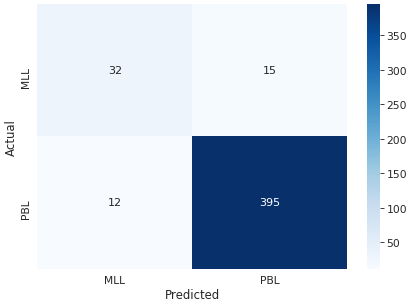

In [219]:
data = np.array([[ 32.,  15.],
                 [ 12., 395.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

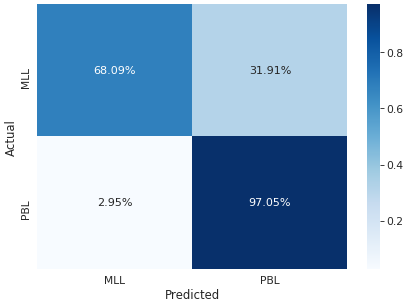

In [222]:
data = np.array([[ 32.,  15.],
                 [ 12., 395.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet3

In [287]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 10
classes_n = 4

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-3
Validation:
TPR=[0.59       0.85743902 0.62953846 0.68398693], TNR=[0.98060535 0.80476732 0.91024066 0.91448459], PPV=[0.65666667 0.79781998 0.74704122 0.67093301], NPV=[0.9772006  0.87203288 0.86158184 0.92263742], FPR=[0.01939465 0.19523268 0.08975934 0.08551541], FNR=[0.41       0.14256098 0.37046154 0.31601307], FDR=[0.34333333 0.20218002 0.25295878 0.32906699], ACC=[0.95989952 0.8293067  0.83044185 0.86941964], F1_micro=0.7445338509392239, F1_macro=0.6947980905146112, F1_weighted=0.7411311681086528
[[ 28.  12.   1.   6.]
 [  9. 349.  32.  17.]
 [  0.  55. 156.  37.]
 [  7.  24.  23. 117.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.64      0.60      0.62        47
       Pigmented_benign       0.79      0.86      0.82       407
        Keratin_lesions       0.74      0.63      0.68       248
Nonmelanoma_skin_cancer       0.66      0.68      0.67       171

               accuracy                           0.74 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.72436477 0.90368298], TNR=[0.90368298 0.72436477], PPV=[0.72310862 0.90863735], NPV=[0.90863735 0.72310862], FPR=[0.09631702 0.27563523], FNR=[0.27563523 0.09631702], FDR=[0.27689138 0.09136265], ACC=[0.85915318 0.85915318], F1_micro=0.8591531797526184, F1_macro=0.8127120672766438, F1_weighted=0.8592529407795221
[[158.  60.]
 [ 63. 592.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.71      0.72      0.72       218
       PB+KL       0.91      0.90      0.91       655

    accuracy                           0.86       873
   macro avg       0.81      0.81      0.81       873
weighted avg       0.86      0.86      0.86       873

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.91018826 0.98007475 0.91220743 0.95581445], TNR=[0.99784838 0.95017205 0.98791426 0.98702004], PPV=[0.96168283 0.94578113 0.96797333 0.9476023 ], NPV=[0.99490723 0.98217582 0.96624417 0.98925734], FPR=[0.00215

TPR=[0.9893012 1.       ], TNR=[1.        0.9893012], PPV=[1.         0.99645183], NPV=[0.99645183 1.        ], FPR=[0.        0.0106988], FNR=[0.0106988 0.       ], FDR=[0.         0.00354817], ACC=[0.99732759 0.99732759], F1_micro=0.997327594339608, F1_macro=0.9964205230852636, F1_weighted=0.9973222431249977
[[1941.   21.]
 [   0. 5895.]]
              precision    recall  f1-score   support

  MLL+NonMSC       1.00      0.99      0.99      1962
       PB+KL       1.00      1.00      1.00      5895

    accuracy                           1.00      7857
   macro avg       1.00      0.99      1.00      7857
weighted avg       1.00      1.00      1.00      7857

--------------------------------
--------------------------------
Layers-3, Set-3
Validation:
TPR=[0.635      0.8625     0.73024359 0.68366013], TNR=[0.97098149 0.85847145 0.89912954 0.94164815], PPV=[0.56238095 0.84159509 0.74956588 0.74060659], NPV=[0.97928116 0.87922242 0.89415886 0.92521374], FPR=[0.02901851 0.14152855 0.100

TPR=[1.         0.99972678 0.99596611 0.9883032 ], TNR=[1.         0.99356118 0.99982206 1.        ], PPV=[1.         0.99268582 0.99955556 1.        ], NPV=[1.         0.9997619  0.998403   0.99715939], FPR=[0.         0.00643882 0.00017794 0.        ], FNR=[0.         0.00027322 0.00403389 0.0116968 ], FDR=[0.         0.00731418 0.00044444 0.        ], ACC=[1.         0.9964362  0.99872725 0.99770895], F1_micro=0.9964361991501131, F1_macro=0.9970158991389985, F1_weighted=0.9964345537114973
[[4.230e+02 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 3.662e+03 1.000e+00 0.000e+00]
 [0.000e+00 9.000e+00 2.223e+03 0.000e+00]
 [0.000e+00 1.800e+01 0.000e+00 1.521e+03]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       1.00      1.00      1.00       423
       Pigmented_benign       0.99      1.00      1.00      3663
        Keratin_lesions       1.00      1.00      1.00      2232
Nonmelanoma_skin_cancer       1.00      0.99      0.99      1539

   

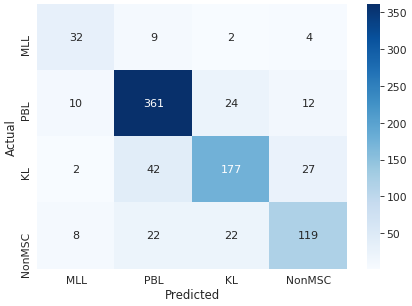

In [215]:
data = np.array([[ 32.,   9.,   2.,   4.],
                 [ 10., 361.,  24.,  12.],
                 [  2.,  42., 177.,  27.],
                 [  8.,  22.,  22., 119.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC'], index = ['MLL', 'PBL', 'KL', 'NonMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

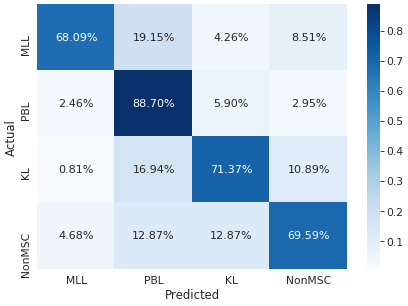

In [223]:
data = np.array([[ 32.,   9.,   2.,   4.],
                 [ 10., 361.,  24.,  12.],
                 [  2.,  42., 177.,  27.],
                 [  8.,  22.,  22., 119.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC'], index = ['MLL', 'PBL', 'KL', 'NonMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet4

In [291]:
layers = [1,2,3,4,5]
sets = [4]

folds_n = 10
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
          
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
              
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-4
Validation:
TPR=[0.7   0.975], TNR=[0.975 0.7  ], PPV=[0.80880952 0.96771015], NPV=[0.96771015 0.80880952], FPR=[0.025 0.3  ], FNR=[0.3   0.025], FDR=[0.19119048 0.03228985], ACC=[0.94812175 0.94812175], F1_micro=0.9481217490519815, F1_macro=0.8521079095712469, F1_weighted=0.9475644662968434
[[ 30.  13.]
 [ 10. 385.]]
              precision    recall  f1-score   support

         C43       0.75      0.70      0.72        43
         D22       0.97      0.97      0.97       395

    accuracy                           0.95       438
   macro avg       0.86      0.84      0.85       438
weighted avg       0.95      0.95      0.95       438

--------------------------------
--------------------------------
--------------------------------
Training:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[1. 1.], TNR=[1. 1.], PPV=[1. 1.], NPV=[1. 1.], FPR=[0. 0.], FNR=[0. 0.], FDR=[0. 0.], ACC=[1. 1.], F1_micro=1.0, F1_macro=1.0, F1_weighted=1.0
[[ 387.    0.]
 [   0. 3555.]]
              precision    recall  f1-score   support

         C43       1.00      1.00      1.00       387
         D22       1.00      1.00      1.00      3555

    accuracy                           1.00      3942
   macro avg       1.00      1.00      1.00      3942
weighted avg       1.00      1.00      1.00      3942

--------------------------------
--------------------------------
Layers-2, Set-4
Validation:
TPR=[0.725     0.9749359], TNR=[0.9749359 0.725    ], PPV=[0.785      0.97064103], NPV=[0.97064103 0.785     ], FPR=[0.0250641 0.275    ], FNR=[0.275     0.0250641], FDR=[0.215      0.02935897], ACC=[0.95024061 0.95024061], F1_micro=0.9502406121010774, F1_macro=0.8504484917675716, F1_weighted=0.948531596637596
[[ 31.  12.]
 [ 10. 385.]]
              precision    recall  f1-score   support

      

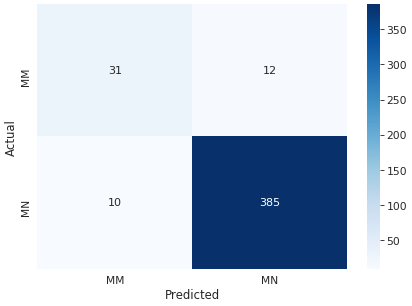

In [296]:
data = np.array([[ 31.,  12.],
                 [ 10., 385.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

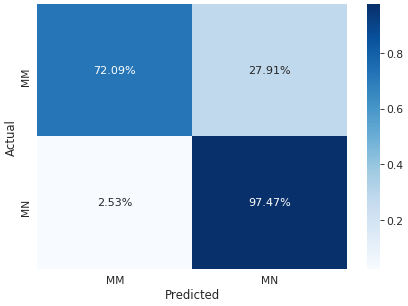

In [297]:
data = np.array([[ 31.,  12.],
                 [ 10., 385.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]

# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet8

In [289]:
layers = [1,2,3,4, 5]
sets = [8]

folds_n = 10
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
        val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.655      0.74670732 0.56198718 0.51405229 0.72211765], TNR=[0.9827741  0.88178025 0.94341468 0.94383338 0.79175536], PPV=[0.5797619  0.73034127 0.69271666 0.56352753 0.67610792], NPV=[0.98796389 0.89349008 0.90824037 0.93250159 0.83133381], FPR=[0.0172259  0.11821975 0.05658532 0.05616662 0.20824464], FNR=[0.345      0.25329268 0.43801282 0.48594771 0.27788235], FDR=[0.4202381  0.26965873 0.30728334 0.43647247 0.32389208], ACC=[0.97178    0.8421076  0.87469076 0.89070178 0.76611719], F1_micro=0.6726986674703397, F1_macro=0.6373949139492103, F1_weighted=0.66965357888936
[[ 31.   7.   0.   5.   4.]
 [  7. 304.  21.  10.  65.]
 [  2.  34. 139.  13.  60.]
 [  9.   6.  15.  88.  53.]
 [  5.  68.  28.  40. 367.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.57      0.66      0.61        47
       Pigmented_benign       0.73      0.75      0.74       407
        Keratin_lesions       0.68      0.56      0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.61006023 0.93383436], TNR=[0.93383436 0.61006023], PPV=[0.63357883 0.92761146], NPV=[0.92761146 0.63357883], FPR=[0.06616564 0.38993977], FNR=[0.38993977 0.06616564], FDR=[0.36642117 0.07238854], ACC=[0.88274097 0.88274097], F1_micro=0.8827409668583762, F1_macro=0.7753009263441054, F1_weighted=0.881649215922617
[[ 133.   85.]
 [  77. 1086.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.63      0.61      0.62       218
 PB+KL+Other       0.93      0.93      0.93      1163

    accuracy                           0.88      1381
   macro avg       0.78      0.77      0.78      1381
weighted avg       0.88      0.88      0.88      1381

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.87674419 0.90828978 0.80328422 0.80699431 0.91338519], TNR=[0.99483604 0.95425141 0.9885271  0.98255372 0.9045341 ], PPV=[0.86016981 0.8933353  0.94046225 0.8698308  0.85122848], NPV=[0.99566851 0.96169756 

TPR=[0.99761905 0.99941701], TNR=[0.99941701 0.99761905], PPV=[0.98438046 0.9999166 ], NPV=[0.9999166  0.98438046], FPR=[0.00058299 0.00238095], FNR=[0.00238095 0.00058299], FDR=[1.56195422e-02 8.34028357e-05], ACC=[0.99935627 0.99935627], F1_micro=0.9993562661624764, F1_macro=0.9952211006566302, F1_weighted=0.9993651272170485
[[4.2200e+02 1.0000e+00]
 [7.0000e+00 1.1999e+04]]
                    precision    recall  f1-score   support

               MLL       0.98      1.00      0.99       423
PB+KL+NonMSC+Other       1.00      1.00      1.00     12006

          accuracy                           1.00     12429
         macro avg       0.99      1.00      1.00     12429
      weighted avg       1.00      1.00      1.00     12429

--------------------------------
Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:
TPR=[0.98216865 0.99828062], TNR=[0.99828062 0.98216865], PPV=[0.99084324 0.99666329], NPV=[0.99666329 0.99084324], FPR=[0.00171

                    precision    recall  f1-score   support

               MLL       0.54      0.60      0.57        47
PB+KL+NonMSC+Other       0.99      0.98      0.98      1334

          accuracy                           0.97      1381
         macro avg       0.76      0.79      0.77      1381
      weighted avg       0.97      0.97      0.97      1381

--------------------------------
Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:
TPR=[0.6158291 0.9501621], TNR=[0.9501621 0.6158291], PPV=[0.70349119 0.92952945], NPV=[0.92952945 0.70349119], FPR=[0.0498379 0.3841709], FNR=[0.3841709 0.0498379], FDR=[0.29650881 0.07047055], ACC=[0.89728148 0.89728148], F1_micro=0.8972814766276475, F1_macro=0.7969339634921022, F1_weighted=0.8944891512727974
[[ 134.   84.]
 [  58. 1105.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.70      0.61      0.65       218
 PB+KL+Other       0.93      0.95      0.94      1163



TPR=[0.98166627 0.99933124], TNR=[0.99933124 0.98166627], PPV=[0.99641274 0.99657394], NPV=[0.99657394 0.99641274], FPR=[0.00066876 0.01833373], FNR=[0.01833373 0.00066876], FDR=[0.00358726 0.00342606], ACC=[0.99654076 0.99654076], F1_micro=0.996540755293658, F1_macro=0.9934488651530682, F1_weighted=0.9965278113221236
[[1.926e+03 3.600e+01]
 [7.000e+00 1.046e+04]]
              precision    recall  f1-score   support

  MLL+NonMSC       1.00      0.98      0.99      1962
 PB+KL+Other       1.00      1.00      1.00     10467

    accuracy                           1.00     12429
   macro avg       1.00      0.99      0.99     12429
weighted avg       1.00      1.00      1.00     12429

--------------------------------
--------------------------------
--------------------------------


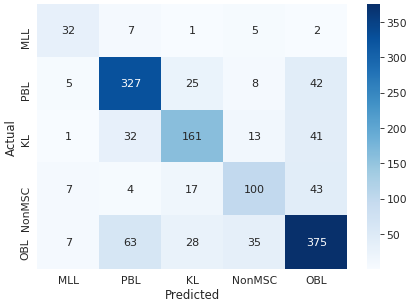

In [217]:
data = np.array([[ 32.,   7.,   1.,   5.,   2.],
                 [  5., 327.,  25.,   8.,  42.],
                 [  1.,  32., 161.,  13.,  41.],
                 [  7.,   4.,  17., 100.,  43.],
                 [  7.,  63.,  28.,  35., 375.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

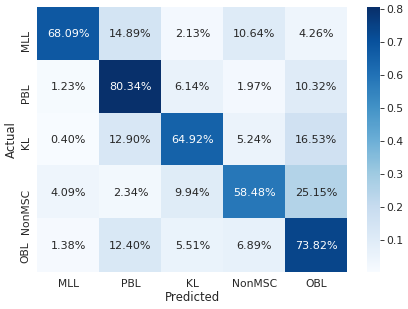

In [225]:
data = np.array([[ 32.,   7.,   1.,   5.,   2.],
                 [  5., 327.,  25.,   8.,  42.],
                 [  1.,  32., 161.,  13.,  41.],
                 [  7.,   4.,  17., 100.,  43.],
                 [  7.,  63.,  28.,  35., 375.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

# Playground

In [191]:


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [202]:
# plot_confusion_matrix(cm           = np.array([[ 32.,   7.,   1.,   5.,   2.],
#                                              [  5., 327.,  25.,   8.,  42.],
#                                              [  1.,  32., 161.,  13.,  41.],
#                                              [  7.,   4.,  17., 100.,  43.],
#                                              [  7.,  63.,  28.,  35., 375.]]), 
#                       normalize    = False,
#                       target_names = ['MLL', 'PBL', 'KL', 'NonMSC', 'Other'],
#                       title        = "Confusion Matrix")

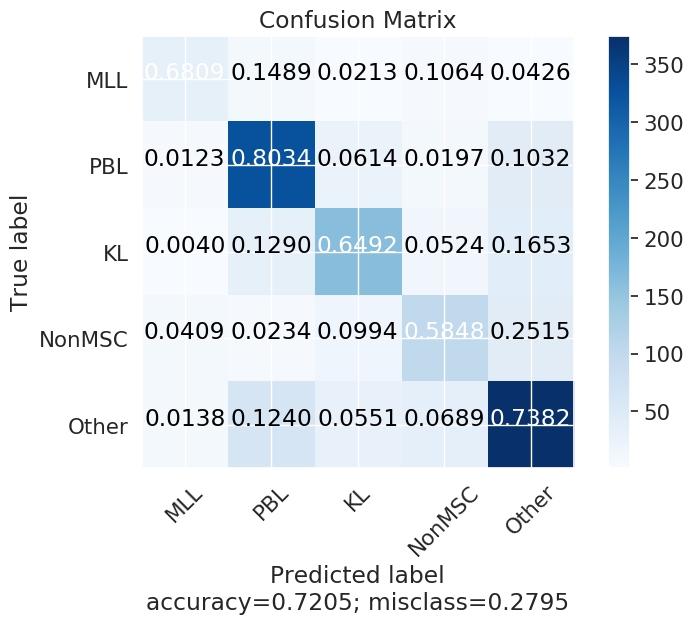

In [193]:
# fig = plt.figure(figsize=(6, 6), dpi=300)
plot_confusion_matrix(cm           = np.array([[ 32.,   7.,   1.,   5.,   2.],
                                             [  5., 327.,  25.,   8.,  42.],
                                             [  1.,  32., 161.,  13.,  41.],
                                             [  7.,   4.,  17., 100.,  43.],
                                             [  7.,  63.,  28.,  35., 375.]]), 
                      normalize    = True,
                      target_names = ['MLL', 'PBL', 'KL', 'NonMSC', 'Other'],
                      title        = "Confusion Matrix")